# Bureau of Labor Statistics: Processing Producer Price Index
_By Nick Brooks, Date: December 2017_

## Content
1. [Reading Multiple Files](#p1)
1. Regular Expressions
1. [New Variables: Age (how long since present), Minimum (Starting Year)](#p3)
1. [Datetime Conversion](#p4)
1. [Merging datasets by ID to append important categorizing information](#p5)
1. [Normalize: Calculate value difference by Series_ID](#p6)
1. [Data Visualization](#p7)

In [1]:
# General
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Warnings OFF
import warnings
warnings.filterwarnings('ignore')

In [2]:
# File Names
ppi_df = pd.DataFrame(os.listdir('../input/ppi/'), columns=["name"])

# Determine file purpose (prices or supportive files)
ppi_df["type"] = ppi_df.name.apply(lambda x: x.split('.')[1])

# Extract Industry Name
ppi_df["industry"] = "none"
ppi_df["industry"] = ppi_df.loc[ppi_df.type == "data","name"].apply(lambda x: x.split('.')[3])

## Reading Multiple Files and Concatenate
<a id="ch1"></a>

In [3]:
# Read Name and Industry Name
indus_file = ppi_df.loc[ppi_df.type == "data",["name","industry"]]

out = pd.DataFrame(index=None)
for index, row in indus_file.iterrows():
    df = pd.read_csv("../input/ppi/{}".format(row[0]),
                               usecols=["series_id","year","period","value"])
    df["industry"] = row[1]
    df.period = df.period.str.replace("M","").astype(int)
    out = pd.concat([out, df], axis=0)
out.shape

(2250958, 5)

## New Variables: Age (how long since present), Minimum (Starting Year)
<a id="ch3"></a>

In [4]:
# Find minimum by Year
out["minimum"] = 'none'
indus_min = []
# Loop by Industry
for x in out.industry.unique():
    # Minimum
    mini = out.loc[out.industry=="Wood", "year"].min()
    # List of Minimums
    indus_min.append([x,mini])
    # Variable
    out.minimum[out.industry==x] = mini
indus_min= pd.DataFrame(indus_min, columns=["Industry","MinimumYear"])

# Time from present
out["frompresent"]= (2017 - out.year)
out['age'] = (out.year - out.minimum)

## Datetime Conversion
<a id="ch4"></a>

In [5]:
# Annual Aggregates
aggregate = out.loc[out.period>12,:]

# Remove Aggregates, saved under month 13, to convert to date time
out = out[out.period != 13]

# Convert to pandas datetime format
out.loc[:,'date'] = pd.to_datetime(out.apply(
    lambda x:'%s-%s-01' % (x['year'],x['period']),axis=1))

In [6]:
# View Supportive Files
helper_file = ppi_df.loc[(ppi_df.type != "data") &
    (~ppi_df['name'].isin(["pc.contacts","pc.txt"])),["name"]]

print(ppi_df.loc[ppi_df.type!= "data",["name","type"]])

for index, row in helper_file.iterrows():
    print("\n",row[0])
    df = pd.read_csv("../input/ppi/{}".format(row[0]))
    print(df.head())

               name      type
8   pc.industry.csv  industry
16           pc.txt       txt
18      pc.contacts  contacts
22  pc.footnote.csv  footnote
23    pc.series.csv    series
62    pc.period.csv    period
64   pc.product.csv   product

 pc.industry.csv
  Unnamed: 0           industry_code  industry_name
0     1133--                 Logging            NaN
1     11331-                 Logging            NaN
2     113310                 Logging            NaN
3     211---  Oil and gas extraction            NaN
4     2111--  Oil and gas extraction            NaN

 pc.footnote.csv
  Unnamed: 0                                      footnote_code  footnote_text
0          P  Preliminary. All indexes are subject to revisi...            NaN
1          R                                            Revised            NaN

 pc.series.csv
   Unnamed: 0                       series_id industry_code product_code  \
0           0  PCU1133--1133--                       1133--       1133--   
1      

In [7]:
# Load Helper Files to ID product types
series = pd.read_csv("../input/ppi/pc.series.csv",index_col=0)
industry = pd.read_csv("../input/ppi/pc.industry.csv").iloc[:,0:2]
industry.columns = ["industry_code","industry_name"]
product = pd.read_csv("../input/ppi/pc.product.csv").iloc[:,0:3]
product.columns = ["industry_code","product_code","product_name"]

## Merging datasets by ID to append important categorizing information
<a id="ch5"></a>

In [8]:
# oh baby a triple
data = pd.merge(
        pd.merge(series.iloc[:,0:3],
             pd.merge(product, industry,
                      on='industry_code', how='outer'),
                 on=["industry_code","product_code"], how="outer"),
        out, on="series_id", how="right", suffixes=["sup", " "])

# Series_id has empty spaces at the end.
data.series_id = [x.replace(" ", "") for x in data.series_id ]

In [9]:
data.sample(15)

,series_id,industry_code,product_code,product_name,industry_name,year,period,value,industry,minimum,frompresent,age,date
1494711,PCU336320336320M,336320,336320M,Miscellaneous receipts,Motor vehicle electrical and electronic equipm...,2006,2,133.0,Current,1967,11,39,2006-02-01
759910,PCU325998325998J,325998,325998J,"All other chemical preparations, incl. essenti...",Other miscellaneous chemical product mfg.,1995,2,122.0,Chemicals,1967,22,28,1995-02-01
1460051,PCU3359913359913,335991,3359913,All other carbon and graphite products,Carbon and graphite product mfg,2009,9,118.7,ElectricalMachinery,1967,8,42,2009-09-01
1877195,PCU51119-51119-,51119-,51119-,Other publishers,Other publishers,2007,3,107.6,Current,1967,10,40,2007-03-01
1633445,PCU33993-33993-,33993-,33993-,"Doll, toy & game mfg","Doll, toy & game mfg",2008,12,109.5,Current,1967,9,41,2008-12-01
833708,PCU3271203271204,327120,3271204,Clay refractories,Clay building material and refractories manufa...,2005,1,105.7,Current,1967,12,38,2005-01-01
1000357,PCU3323123323121,332312,3323121,Fabricated structural metal bar joists and con...,Fabricated structural metal mfg,2008,6,203.5,Current,1967,9,41,2008-06-01
548216,PCU3222203222202,322220,3222202,Coated and laminated paper,Paper bag and coated and treated paper manufac...,2010,5,123.3,Paper,1967,7,43,2010-05-01
682391,PCU325412325412,325412,325412,Pharmaceutical preparation manufacturing,Pharmaceutical preparation manufacturing,2002,3,323.7,Current,1967,15,35,2002-03-01
235415,PCU311611311611J,311611,311611J,"Sausage/similar products, exc. canned, slaught...","Animal, except poultry, slaughtering",1976,11,57.8,Food,1967,41,9,1976-11-01


In [10]:
[print(y, x.shape) for (x,y) in [(industry, 'industry_df'), (product, 'product_df'),
                                 (industry, 'industry_df'),(out, 'main_dataset')]]
print("\nUnique Categories:")
print("Unique Product Category Count:", len(product.product_name.unique()))
print("Unique Industry Category Count:", len(industry.industry_name.unique()))
print("Data Unique Industry Count:", len(out.industry.unique()))
print("\nOuter-Merged Dataset:")
[print("{}:".format(x), len(data[x].unique()))for x in ["product_name","industry_name","industry"]]
print("shape:", data.shape)
print("\nMissing? ", data.isnull().values.any())

del out, series, industry, product

industry_df (1064, 2)
product_df (5172, 3)
industry_df (1064, 2)
main_dataset (2086023, 9)

Unique Categories:
Unique Product Category Count: 3472
Unique Industry Category Count: 845
Data Unique Industry Count: 71

Outer-Merged Dataset:
product_name: 3472
industry_name: 845
industry: 71
shape: (2086023, 13)

Missing?  False


In [11]:
current = data[data.industry=="Current"]
print("'Current' Industry:")
print("Observation Count:", current.shape[0])
print("Unique Sub-Industries:", len(current.industry_name.unique()))
print("Unique Products:", len(current.product_name.unique()))

'Current' Industry:
Observation Count: 827627
Unique Sub-Industries: 845
Unique Products: 3465


In [12]:
# Show the sub-industries and sub-products
industry_unique = pd.DataFrame()
for x in data.industry.unique():
    industry_unique = industry_unique.append({"Industry": x,
                                              "Sub-Industries": len(data[data.industry==x].industry_name.unique()),
                                              "Total Products": len(data[data.industry==x].product_name.unique())},
                                            ignore_index=True)
    #print(x, len(data[data.industry==x].industry_name.unique()), len(data[data.industry==x].product_name.unique()))
    
industry_unique.sort_values(by=["Total Products"], ascending=False, inplace=True)
industry_unique.reset_index(drop=True, inplace=True)
pd.concat([industry_unique[:35], industry_unique[35:].reset_index(drop=True)], axis=1)

,Industry,Sub-Industries,Total Products,Industry,Sub-Industries,Total Products
0,Current,845.0,3465.0,FoodBeverageStores,6.0,29.0
1,Machinery,55.0,291.0,TransportationSupport,11.0,28.0
2,Food,70.0,285.0,RealEstate,9.0,23.0
3,Chemicals,51.0,234.0,Leather,6.0,22.0
4,FabricatedMetalProduct,53.0,228.0,PostalService,1.0,22.0
5,TransportationEquipment,36.0,159.0,SportsMusicStores,10.0,21.0
6,PrimaryMetal,30.0,125.0,AirTransportation,7.0,21.0
7,NonmetallicMineral,28.0,111.0,Accommodation,4.0,20.0
8,Miscellaneous,23.0,108.0,RentalandLeasingServices,6.0,18.0
9,PlasticsRubberProducts,28.0,105.0,MotorVehicleDealers,8.0,18.0


##  Normalize: Calculate value difference by Series_ID 
<a id="p6"></a>

In [13]:
# Calculate Difference by period and by Series_Id
data.set_index("date", inplace=True)
data.sort_index(inplace=True)
data['value_diffs'] = data.groupby('series_id')['value'].transform(pd.Series.diff)

## Exploratory Data Analysis
<a id="p7"></a>

Plot value difference over time
- histograms, or perhaps line plots by industry?

In [25]:
data.sample(5)

,series_id,industry_code,product_code,product_name,industry_name,year,period,value,industry,minimum,frompresent,age,value_diffs
date,,,,,,,,,,,,,
1995-03-01,PCU332911332911B,332911,332911B,All other miscellaneous industrial valves,Industrial valve mfg,1995,3,115.1,FabricatedMetalProduct,1967,22,28,0.3
2005-09-01,PCU483211483211,483211,483211,Inland water freight transportation,Inland water freight transportation,2005,9,164.3,Current,1967,12,38,10.8
2013-03-01,PCU3273903273901,327390,3273901,Precast concrete products,Other concrete product manufacturing,2013,3,253.4,NonmetallicMineral,1967,4,46,0.1
2001-01-01,PCU5151105151101,515110,5151101,Radio station services,Radio broadcasting,2001,1,172.2,Broadcasting,1967,16,34,0.0
2016-06-01,PCU332913332913,332913,332913,Plumbing fixture fitting and trim mfg,Plumbing fixture fitting and trim mfg,2016,6,269.3,Current,1967,1,49,0.0


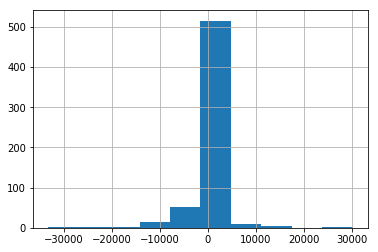

In [14]:
#data.loc[(data["value_diffs"] > 1000) | (data["value_diffs"] < -1000), :]
data.loc[data.series_id== "PCU33441333441312", "value_diffs"].hist()

In [28]:
list(set(data.product_name[data.industry == "ForestryandLogging"]))

['Primary products', 'Logging', 'Miscellaneous receipts']

In [ ]:
# Try: Log, rolling average, aggregate by industry.. Correlate.
# V1 
cat = "OilAndGas"
for x in set(data.product_name[data.industry == cat]):
    data.value_diffs[data.product_name == x].plot(alpha= 0.5, label = x, title=cat)
    
plt.legend(fontsize='large', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# V2

In [ ]:
cat = "OilAndGas"
for x in set(data.product_name[data.industry == cat]):
    data.value_diffs[data.product_name == x].rolling(window = 12).mean()\
    .plot(alpha= 0.5, label = x, title=cat)
    
plt.legend(fontsize='large', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
sns.tsplot(data.loc[data.industry== "ForestryandLogging", unit='Kind', condition='Company', value='Price')

SyntaxError: invalid syntax (<ipython-input-15-3d8d2eb86450>, line 1)

In [ ]:
data.loc[~(data.series_id == "PCU33441333441312"), ["value_diffs"]].plot(legend=False) #hist(bins=30)

In [ ]:
sns.kdeplot(data.loc[~(data.series_id == "PCU33441333441312"), ["value_diffs"]], shade=True);

In [ ]:
data["value_diffs"].plot()

## Output Processed Data

In [ ]:
data.to_csv("Aggregated_BLS_Producer_Price.csv")